In [2]:
import numpy as np
import random
import torch as t
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

/Users/paul/anaconda3/envs/acd/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Create animal related sentences and non-animal related sentence. Will do this by concantenating sentences like "I like " with animal or non-related words like "cats" and "physics".
# 100 of animal and non-animal words

animal_words = [
    "cats", "dogs", "elephants", "tigers", "birds",
    "lions", "giraffes", "bears", "wolves", "dolphins",
    "sharks", "rabbits", "deer", "frogs", "snakes",
    "lizards", "fish", "whales", "penguins", "bees",
    "ants", "butterflies", "turtles", "owls", "squirrels",
    "foxes", "leopards", "kangaroos", "zebras", "rhinoceros",
    "hippos", "cheetahs", "gorillas", "monkeys", "parrots",
    "crocodiles", "alligators", "eagles", "stallions", "pigeons",
    "turkeys", "chickens", "horses", "rats", "mice",
    "moths", "otters", "octopuses", "crabs", "starfish",
    "jellyfish", "seahorses", "salamanders", "cicadas", "locusts",
    "spiders", "cows", "pigs", "goats", "sheep",
    "donkeys", "mules", "buffalos", "hedgehogs", "porcupines",
    "raccoons", "kookaburras", "magpies", "roosters", "falcons",
    "caribou", "elk", "moose", "lynxes", "ostriches",
    "peacocks", "swans", "geese", "ducks", "bison",
    "chameleons", "cobras", "vultures", "hawks", "skunks",
    "weasels", "walruses", "seals", "narwhals", "platypuses",
    "echidnas", "dingoes", "hyenas", "jaguars", "panthers"
    "ibex", "lemurs", "marmots", "orioles", "quails", "axolotl"
]

non_animal_words = [
    "automobiles", "bridges", "computers", "diamonds", "electronics",
    "furniture", "guitars", "helicopters", "icebergs", "jewelry",
    "kettles", "lamps", "mountains", "novels", "oceans",
    "paintings", "quilts", "robots", "satellites", "telescopes",
    "umbrellas", "vases", "windmills", "xylophones", "yachts",
    "zippers", "architecture", "ballet", "chemistry", "democracy",
    "economics", "fossils", "geometry", "harmony", "innovation",
    "jazz", "kinetics", "literature", "metaphysics", "nebulae",
    "opera", "philosophy", "quantum", "renaissance", "sculpture",
    "theater", "universities", "volcanoes", "whiskey", "x-rays",
    "yoga", "zeal", "algorithms", "biotechnology", "calculus",
    "deserts", "engineering", "finance", "genomics", "horticulture",
    "ideology", "justice", "kinematics", "logarithms", "metallurgy",
    "nutrition", "orchestras", "physics", "quantification", "rhetoric",
    "statistics", "topography", "urbanism", "virology", "web",
    "exoplanets", "yield", "zenith", "aerospace", "biomes",
    "cryptocurrency", "dynamics", "ethics", "frequencies", "governance",
    "hexagons", "infrastructure", "juxtaposition", "kinship", "landforms",
    "mechanics", "narratives", "ontology", "psychoanalysis", "quarks",
    "relativity", "synthesis", "taxonomy", "utilitarianism", "ventilation",
]

sentence_starters = ["I like ", "I dislike ", "I fear ", "I am fascinated by ", "I avoid ", "I am annoyed by ", "I am intrigued by ", "I am scared of ", "I admire ", "I detest "]


In [4]:
#Generate animal and non-animal sentences

animal_sentences = []
non_animal_sentences = []

for sentence in sentence_starters:
    for i in range(len(animal_words)):
        animal_sentences.append(sentence+animal_words[i]+'.')
        non_animal_sentences.append(sentence+non_animal_words[i]+'.')
    

In [29]:
tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2")
model = AutoModelForCausalLM.from_pretrained("openai-community/gpt2")
tokenizer.pad_token = tokenizer.eos_token

_ = model.eval()

In [6]:
# Global container to store activations
activations = {}

def get_activation(name):
    # closure to store activation
    def hook(model, input, output):
        activations[name] = output[0].detach()
    return hook

# Attaching hooks to each layer of the GPT-2 model
for i, layer in enumerate(model.transformer.h):
    layer.register_forward_hook(get_activation(f'Layer_{i}'))


In [24]:
# Print max number of layers and max number of tokens
print(f"Number of layers = {len(model.transformer.h)}")
inputs_animal = tokenizer(animal_sentences, return_tensors="pt", padding=True, truncation=True)
inputs_non_animal = tokenizer(non_animal_sentences, return_tensors="pt", padding=True, truncation=True)
max_tokens = max(inputs_animal['input_ids'].shape[-1], inputs_non_animal['input_ids'].shape[-1])
print(f"Number of tokens = {max_tokens}")

Number of layers = 12
Number of tokens = 10


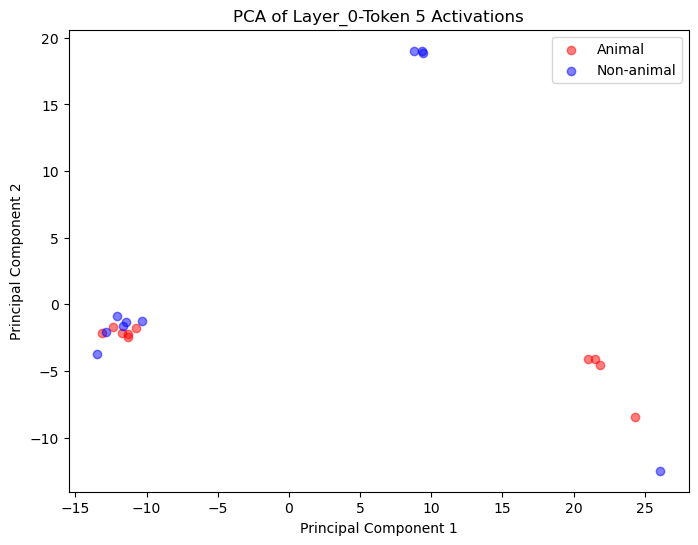

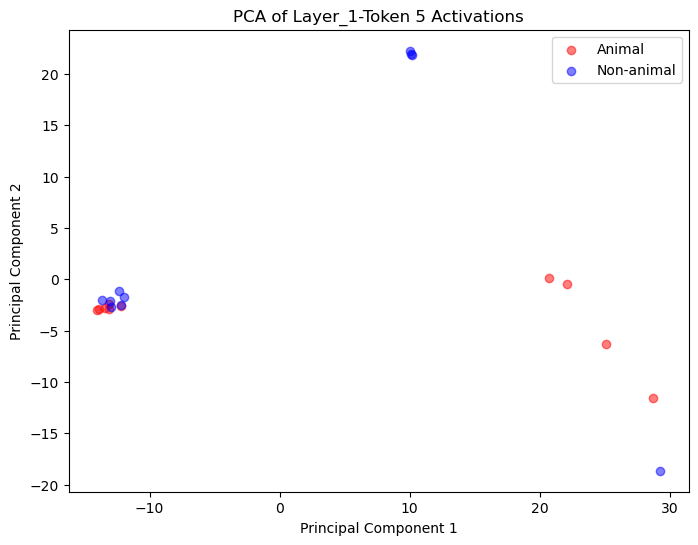

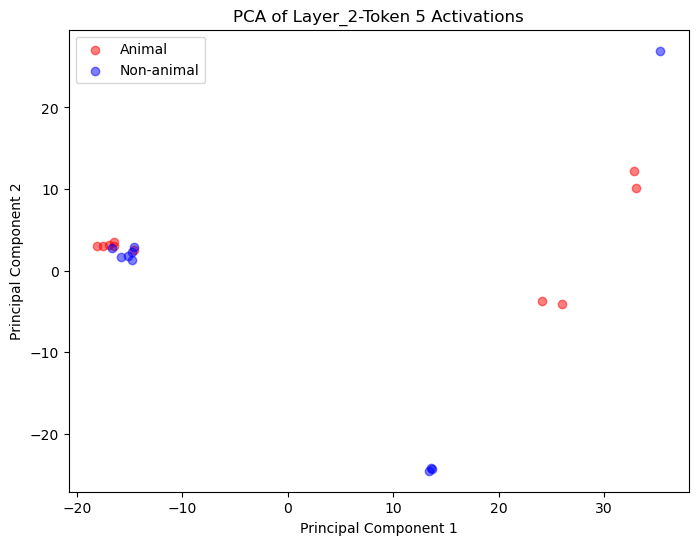

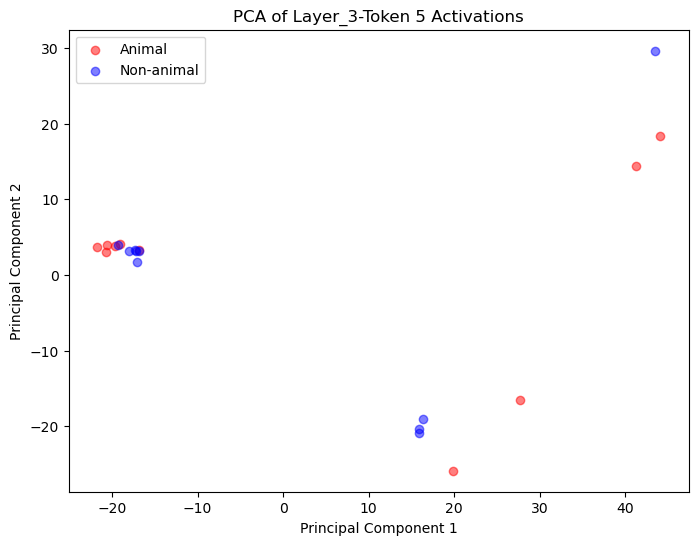

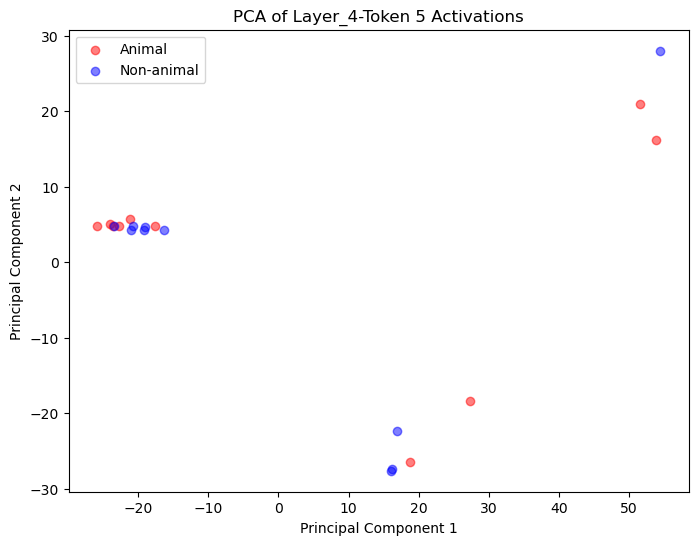

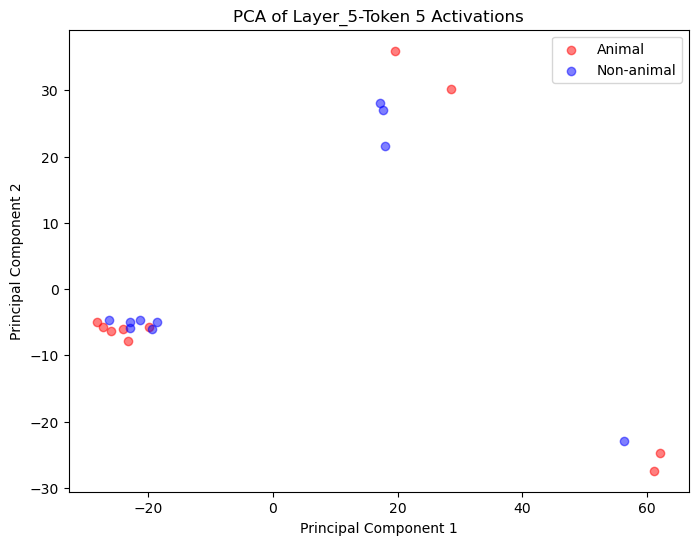

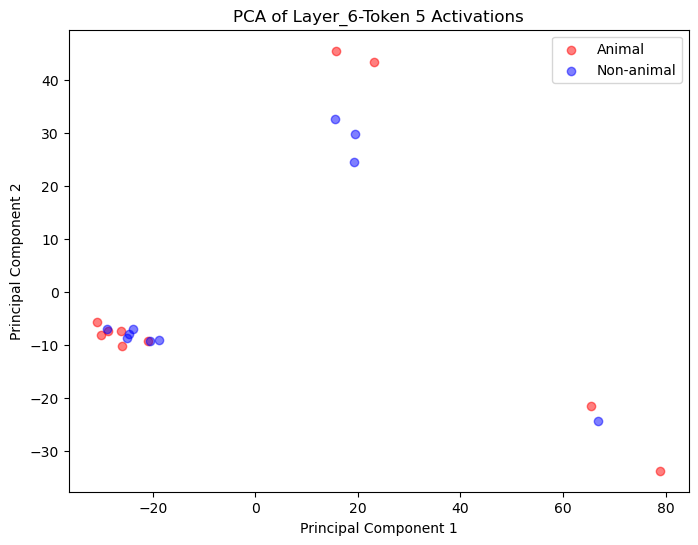

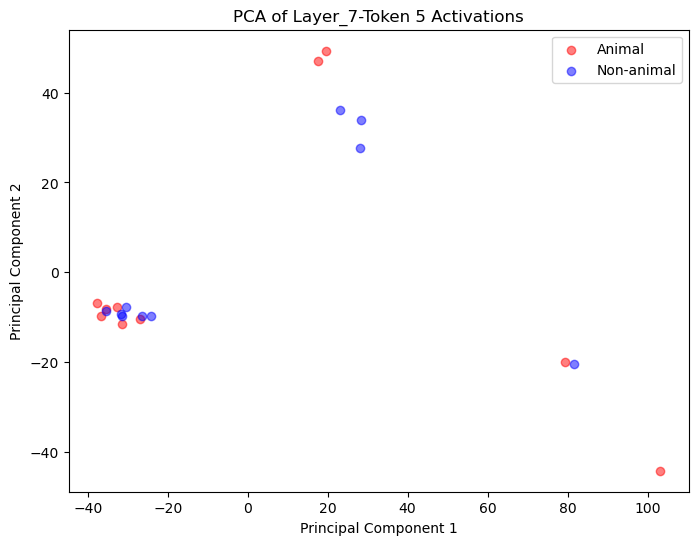

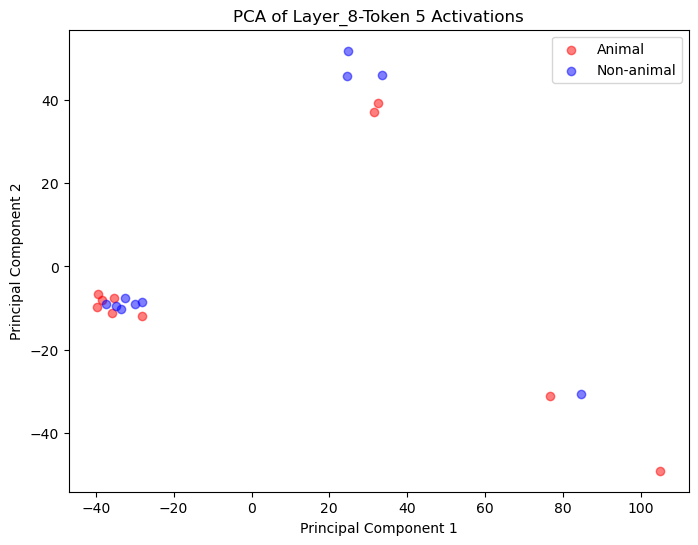

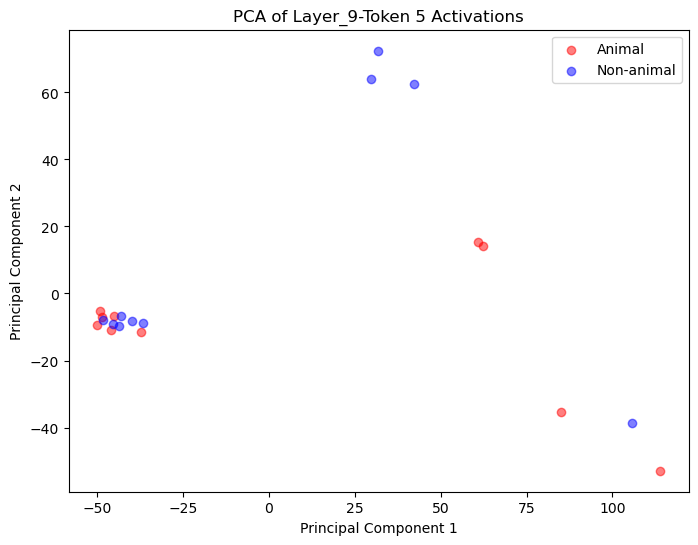

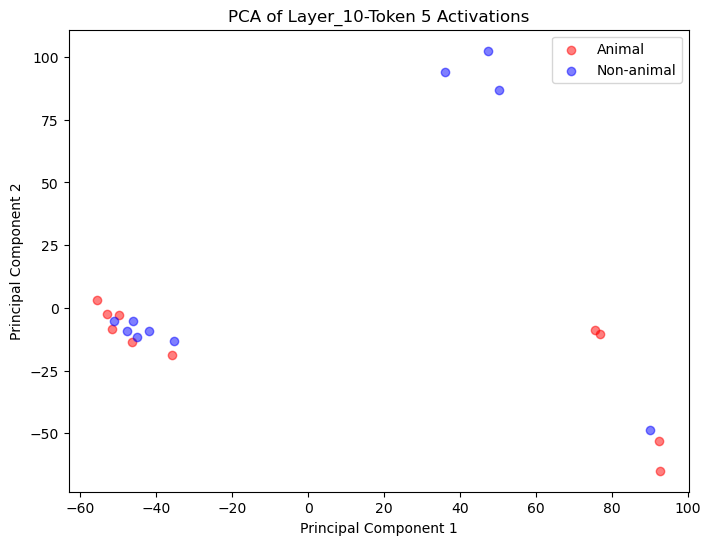

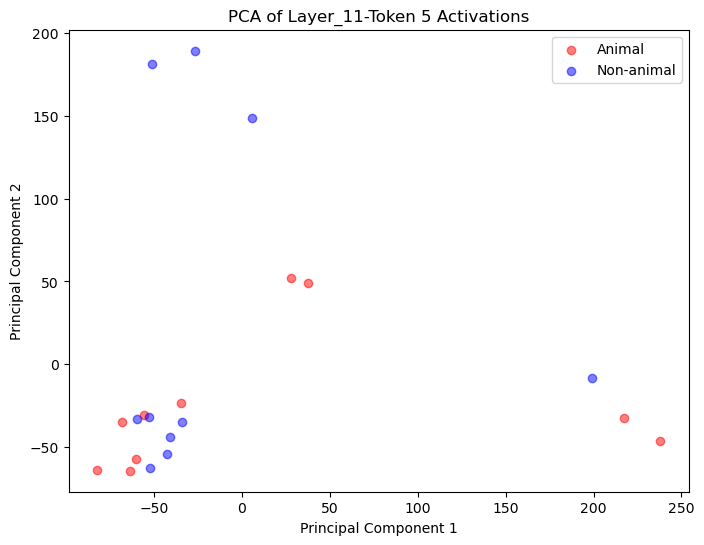

In [27]:
# Parameters for looping
num_samples = 10
layer_names = ['Layer_{}'.format(i) for i in range(0, 12)]  # Adjust as needed based on your model structure
token_indices = [5]  # Example token indices

# Shuffle sentences
random.shuffle(animal_sentences)
random.shuffle(non_animal_sentences)

# Process sentences and get activations
inputs = tokenizer(animal_sentences[0:num_samples], return_tensors="pt", padding=True, truncation=True)
outputs = model(**inputs)
animal_activations = activations.copy()

activations = {}

inputs = tokenizer(non_animal_sentences[0:num_samples], return_tensors="pt", padding=True, truncation=True)
outputs = model(**inputs)
non_animal_activations = activations.copy()

# Loop over each layer and token
for layer_name in layer_names:
    for token_num in token_indices:
        try:
            # Extract activations for the current layer and token
            animal_activations_layer_token = animal_activations[layer_name][:, token_num, :].numpy()
            non_animal_activations_layer_token = non_animal_activations[layer_name][:, token_num, :].numpy()
            
            # Combine datasets
            combined_activations = np.vstack((animal_activations_layer_token, non_animal_activations_layer_token))
            labels = np.array([0] * len(animal_activations_layer_token) + [1] * len(non_animal_activations_layer_token))
            
            # Perform PCA
            pca = PCA(n_components=2)  # 2D for easy plotting
            reduced_activations = pca.fit_transform(combined_activations)
            
            # Plotting
            plt.figure(figsize=(8, 6))
            plt.scatter(reduced_activations[labels == 0, 0], reduced_activations[labels == 0, 1], c='red', label='Animal', alpha=0.5)
            plt.scatter(reduced_activations[labels == 1, 0], reduced_activations[labels == 1, 1], c='blue', label='Non-animal', alpha=0.5)
            plt.xlabel('Principal Component 1')
            plt.ylabel('Principal Component 2')
            plt.legend()
            plt.title(f'PCA of {layer_name}-Token {token_num} Activations')
            plt.show()
            
        except Exception as e:
            print(f"Error processing {layer_name}-Token {token_num}: {e}")
